In this version, some changes are applied to Coinworld/ FX simulator:
- Add trading fee feature
- Add Market price - matched price gap
- Add trading with a proposed balance
- Add cumulative balance

## 1 - Import


In [1]:
import base64
import utils
# import imageio
# import IPython
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from itertools import zip_longest
from collections import deque, namedtuple

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, Lambda, Conv1D
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from statsmodels.iolib.table import SimpleTable



## 2 - Hyperparameters
Run the cell below to set the hyperparameters.

In [2]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.96              # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

BETA_BUY = 1              # Percentage of maximum buy quantity can be executed
BETA_SELL = 1             # Percentage of maximum sell quantity can be executed
trading_fee_rate = 0.001
holding_penalty = 3e-5
exploratory_reward = 5e-4

## 3 - Coinworld Evironment
The goal of Coinworld evironment is to earn profit and maintain it from foreign exchange. Agent is only allow to trade and hold 1 currency at a time.

In [3]:
input = pd.read_pickle(r'C:\Users\Dell\OneDrive\Documents\projects\trading_bot_v0\Processed_Dataset_from_1Jan22_17Feb24.pkl') # Importing dataset from pickle
series = np.array(input[['close', 'RSI','MACD_0', 'MACD_1', 'MACD_2']][-2000:]) # Choosing last 1000 data points in close column


In [ ]:
class Coinworld:
    """
    To create a mock trading environment.
    """


    def __init__(self, series, initial_balance=10, min_trading = 10):
        """
        State = (
            Holding quatity, 
            Average price,  
            Cash balance,
            Market price,
            Other indicators,
                )
        """
        self.series         = series
        market_price_0      = self.series[0, 0]                                     # the initial price is the head of the series
        self.time_stamp     = 0


        # Variables determined account state
        buy_limit = initial_balance/market_price_0

        hold_qty      = float(random.randint(0, 1) * buy_limit)
        avg_price     = 0 if hold_qty == 0 else market_price_0                      # if hold_num == 1 else None
        cash_balance  = initial_balance - hold_qty*avg_price
        hold_duration = 0

        # Acc. state and previous acc. state for reward calculation
        self.acc_state      = (hold_qty, avg_price, cash_balance, hold_duration)    # (hold_state, hold_price)
        self.prev_acc_state = (hold_qty, avg_price, cash_balance, hold_duration)
        self.market_state   = tuple(series[0])

        # State and previous state
        self.state          = self.acc_state + tuple(series[0])                     # initial state is the head of the series, holding no orders
        self.prev_state     = self.acc_state + tuple(series[0])

        # The goal is the end of the series
        self.goal       = tuple(series[-1])
        if len(series) > 1:
            self.done   = False
        elif len(series) == 1:
            self.done = True
        else:
            print('Please recheck the input series')

    def dim(self):
        return len(self.series.shape)

    def reset(self, initial_balance=10, min_trading = 10):
        """
        THIS SHOULD RESET THE SEQUENCE AND RETURN THE INITIAL STATE !!

        """
        self.series         = series
        market_price_0      = self.series[0, 0]                                     # the initial price is the head of the series
        self.time_stamp     = 0

        # Variables determined account state
        buy_limit = initial_balance/market_price_0

        hold_qty      = float(random.randint(0, 1) * buy_limit)
        avg_price     = 0 if hold_qty == 0 else market_price_0                      # if hold_num == 1 else None
        cash_balance  = initial_balance - hold_qty*avg_price
        hold_duration = 0

        # Acc. state and previous acc. state for reward calculation
        self.acc_state      = (hold_qty, avg_price, cash_balance, hold_duration)                   # (hold_state, hold_price)
        self.prev_acc_state = (hold_qty, avg_price, cash_balance, hold_duration)
        self.market_state   = tuple(series[0])

        # State and previous state
        self.state          = self.acc_state + tuple(series[0])                     # initial state is the head of the series, holding no orders
        self.prev_state     = self.acc_state + tuple(series[0])
        
        # The goal is the end of the series
        self.goal       = tuple(series[-1])
        if len(series) > 1:
            self.done   = False
        elif len(series) == 1:
            self.done = True
        else:
            print('Please recheck the input series')
        return self.state


    def update_state(self):
        """
        Note:
        - timestamp should be updated according to real-time
        - Market state
        """
        hold_qty_0, avg_price_0, cash_balance_0, hold_duration_0 = self.prev_acc_state
        hold_qty, avg_price, cash_balance, hold_duration         = self.acc_state
        
        if hold_qty_0 == hold_qty:
            hold_duration += 1
        else:
            hold_duration = 0
        
        self.acc_state = (hold_qty, avg_price, cash_balance, hold_duration)
        # Update time stamp
        self.time_stamp += 1 # Auto add up 1 to current timestamp
        self.prev_market_state = self.market_state
        self.market_state = tuple(self.series[self.time_stamp])
        self.state = self.acc_state + self.market_state

    def Buy(self):

        # Unpacking current account state
        hold_qty, avg_price, cash_balance, hold_duration = self.acc_state

        prev_cash_balance = cash_balance
        # Setting-up a buy order
        market_price     = self.market_state[0]
        buy_price        = market_price *(1+trading_fee_rate)
        buy_limit        = cash_balance/buy_price
        buy_qty          = BETA_BUY*buy_limit

        # Calculating new account state
        avg_price    = (hold_qty*avg_price + buy_price*buy_qty)/(hold_qty+buy_qty)
        hold_qty    += buy_qty
        cash_balance-= buy_qty*buy_price

        if prev_cash_balance == cash_balance: self.done = True
        # Update account state
        self.acc_state   = (hold_qty, avg_price, cash_balance, hold_duration)

    def Sell(self):

        # Unpacking current account state
        hold_qty, avg_price, cash_balance, hold_duration = self.acc_state

        prev_cash_balance = cash_balance
        # Setting-up a sell order
        market_price     = self.market_state[0]
        sell_price       = market_price
        sell_qty         = BETA_SELL*hold_qty
        fee              = sell_qty*sell_price*trading_fee_rate

        # Calculating new account state
        hold_qty        -= sell_qty
        avg_price        = 0 if hold_qty == 0 else avg_price
        cash_balance    += sell_qty*sell_price - fee

        if prev_cash_balance == cash_balance: self.done = True

        # Update account state
        self.acc_state = (hold_qty, avg_price, cash_balance, hold_duration)

    def get_reward(self):
        hold_qty_1, avg_price_1, cash_balance_1, hold_duration_1 = self.acc_state
        hold_qty_0, avg_price_0, cash_balance_0, hold_duration_0 = self.prev_acc_state
        market_price                            = self.market_state[0]
        prev_market_price                       = self.prev_market_state[0]

        previous = hold_qty_0 * avg_price_0  + cash_balance_0
        current  = hold_qty_1 * market_price + cash_balance_1
        reward   = current    - previous
        reward  += exploratory_reward* current
        reward  -= current *hold_duration_1* holding_penalty 

        return reward

    def step(self, action):
        """
        Action is a int:
            1 - Buy
            2 - Sell
            3 - Do nothing
        """
        # To check if it is terminated
        hold_qty, avg_price, cash_balance, *market_state = self.state

        # State from previous timestamp is saved as prev_state
        self.prev_state = self.state

        if self.done == False:

            # Buy - when hold nothing
            if action == 1 and hold_qty == 0:
                self.Buy()

            # Sell - when have something to sell
            elif action == 2 and hold_qty > 0:
                self.Sell()

            # Do nothing - maintain the current hold state
            else:
                self.done = True

            # Update state
            self.update_state()

            reward = self.get_reward()

            # Update done
            if self.market_state == self.goal:
                # reward = 0
                self.done = True


            self.prev_acc_state = self.acc_state

            # print(f'Step {self.time_stamp}: reward: {reward}')
            # print(f'        State: {self.prev_state}')
            # print(f'        State: {self.state} ')
            return np.array(self.state), reward, self.done

        else:
            print('No more steps can be taken')

    def get_state_space_size(self):
        return np.array(self.state).shape

    def get_action_space_size(self):
        return 3



In [16]:
env = Coinworld(series)

In [17]:
list(input.columns)

['open',
 'high',
 'low',
 'close',
 'volume',
 'closeTime',
 'baseAssetVolume',
 'numberOfTrade',
 'takerBuyVolume',
 'takerBuyBaseVolume',
 'Ignore',
 'is_higher',
 'percentage_diff',
 'CDL2CROWS',
 'CDL3BLACKCROWS',
 'CDL3INSIDE',
 'CDL3LINESTRIKE',
 'CDL3OUTSIDE',
 'CDL3STARSINSOUTH',
 'CDL3WHITESOLDIERS',
 'CDLABANDONEDBABY',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'CDLBREAKAWAY',
 'CDLCLOSINGMARUBOZU',
 'CDLCONCEALBABYSWALL',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLDOJI',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLHARAMI',
 'CDLHARAMICROSS',
 'CDLHIGHWAVE',
 'CDLHIKKAKE',
 'CDLHIKKAKEMOD',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'CDLKICKING',
 'CDLKICKINGBYLENGTH',
 'CDLLADDERBOTTOM',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLMATHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLMOR

In [18]:
env.reset()
for i in range(11):
    env.step(1)
    print(env.done)


Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False
Insufficient cash balance to buy.
False


<a name="6"></a>
## 6 - Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

This iterative method converges to the optimal action-value function $Q^*(s,a)$ as $i\to\infty$. This means that the agent just needs to gradually explore the state-action space and keep updating the estimate of $Q(s,a)$ until it converges to the optimal action-value function $Q^*(s,a)$. However, in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate $Q(s,a)$ until it converges to $Q^*(s,a)$.

In the Deep $Q$-Learning, we solve this problem by using a neural network to estimate the action-value function $Q(s,a)\approx Q^*(s,a)$. We call this neural network a $Q$-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a ***Target Network*** and ***Experience Replay***. We will explore these two techniques in the following sections.

In [19]:
state_size = env.get_state_space_size()
num_actions = env.get_action_space_size()

# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

optimizer = Adam(learning_rate=ALPHA)


In [20]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [21]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values) 
    ### END CODE HERE ### 
    
    return loss

In [22]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

<a name="9"></a>
## 9 - Train the Agent

We are now ready to train our agent to solve the Lunar Lander environment. In the cell below we will implement the algorithm in [Fig 3](#7) line by line (please note that we have included the same algorithm below for easy reference. This will prevent you from scrolling up and down the notebook):

* **Line 1**: We initialize the `memory_buffer` with a capacity of $N =$ `MEMORY_SIZE`. Notice that we are using a `deque` as the data structure for our `memory_buffer`.


* **Line 2**: We skip this line since we already initialized the `q_network` in [Exercise 1](#ex01).


* **Line 3**: We initialize the `target_q_network` by setting its weights to be equal to those of the `q_network`.


* **Line 4**: We start the outer loop. Notice that we have set $M =$ `num_episodes = 2000`. This number is reasonable because the agent should be able to solve the Lunar Lander environment in less than `2000` episodes using this notebook's default parameters.


* **Line 5**: We use the `.reset()` method to reset the environment to the initial state and get the initial state.


* **Line 6**: We start the inner loop. Notice that we have set $T =$ `max_num_timesteps = 1000`. This means that the episode will automatically terminate if the episode hasn't terminated after `1000` time steps.


* **Line 7**: The agent observes the current `state` and chooses an `action` using an $\epsilon$-greedy policy. Our agent starts out using a value of $\epsilon =$ `epsilon = 1` which yields an $\epsilon$-greedy policy that is equivalent to the equiprobable random policy. This means that at the beginning of our training, the agent is just going to take random actions regardless of the observed `state`. As training progresses we will decrease the value of $\epsilon$ slowly towards a minimum value using a given $\epsilon$-decay rate. We want this minimum value to be close to zero because a value of $\epsilon = 0$ will yield an $\epsilon$-greedy policy that is equivalent to the greedy policy. This means that towards the end of training, the agent will lean towards selecting the `action` that it believes (based on its past experiences) will maximize $Q(s,a)$. We will set the minimum $\epsilon$ value to be `0.01` and not exactly 0 because we always want to keep a little bit of exploration during training. If you want to know how this is implemented in code we encourage you to take a look at the `utils.get_action` function in the `utils` module.


* **Line 8**: We use the `.step()` method to take the given `action` in the environment and get the `reward` and the `next_state`. 


* **Line 9**: We store the `experience(state, action, reward, next_state, done)` tuple in our `memory_buffer`. Notice that we also store the `done` variable so that we can keep track of when an episode terminates. This allowed us to set the $y$ targets in [Exercise 2](#ex02).


* **Line 10**: We check if the conditions are met to perform a learning update. We do this by using our custom `utils.check_update_conditions` function. This function checks if $C =$ `NUM_STEPS_FOR_UPDATE = 4` time steps have occured and if our `memory_buffer` has enough experience tuples to fill a mini-batch. For example, if the mini-batch size is `64`, then our `memory_buffer` should have at least `64` experience tuples in order to pass the latter condition. If the conditions are met, then the `utils.check_update_conditions` function will return a value of `True`, otherwise it will return a value of `False`.


* **Lines 11 - 14**: If the `update` variable is `True` then we perform a learning update. The learning update consists of sampling a random mini-batch of experience tuples from our `memory_buffer`, setting the $y$ targets, performing gradient descent, and updating the weights of the networks. We will use the `agent_learn` function we defined in [Section 8](#8) to perform the latter 3.


* **Line 15**: At the end of each iteration of the inner loop we set `next_state` as our new `state` so that the loop can start again from this new state. In addition, we check if the episode has reached a terminal state (i.e we check if `done = True`). If a terminal state has been reached, then we break out of the inner loop.


* **Line 16**: At the end of each iteration of the outer loop we update the value of $\epsilon$, and check if the environment has been solved. We consider that the environment has been solved if the agent receives an average of `200` points in the last `100` episodes. If the environment has not been solved we continue the outer loop and start a new episode.

Finally, we wanted to note that we have included some extra variables to keep track of the total number of points the agent received in each episode. This will help us determine if the agent has solved the environment and it will also allow us to see how our agent performed during training. We also use the `time` module to measure how long the training takes. 


**Note:** With this notebook's default parameters, the following cell takes between 10 to 15 minutes to run. 

###  Optimistic Initial Values - Local Minima and Maxima

In [23]:
import numpy as np
from scipy.signal import find_peaks

# Example time series data
data = np.array(series[:,0])
# Set prominence and distance
prominence = None
distance = 100
width = 10

# Find local maxima
peaks, _ = find_peaks(data, prominence=prominence, distance=distance)
print("Local maxima indices:", peaks)
print("Local maxima values:", data[peaks])

# Find local minima by inverting the signal
min_peaks, _ = find_peaks(-data, prominence=prominence, distance=distance)
print("Local minima indices:", min_peaks)
print("Local minima values:", data[min_peaks])


Local maxima indices: [  63  202  346  469  571  705  842  953 1067 1179 1280 1447 1548 1657
 1820 1955]
Local maxima values: [52044.01171875 51959.7890625  51795.76171875 51783.83984375
 51592.69921875 51161.03125    51254.6015625  51434.
 52009.578125   51636.8515625  51792.94921875 51461.98828125
 51683.94921875 51738.37890625 52051.98828125 51865.        ]
Local minima indices: [  99  290  399  529  661  766  872  991 1137 1251 1389 1493 1622 1737
 1890 1991]
Local minima values: [51819.76171875 51744.01171875 51509.98828125 51569.6015625
 50650.03125    50762.01953125 51175.25       51320.01171875
 51597.16015625 51545.48046875 51211.1015625  51524.46875
 51407.44140625 51719.91015625 51720.140625   51547.01171875]


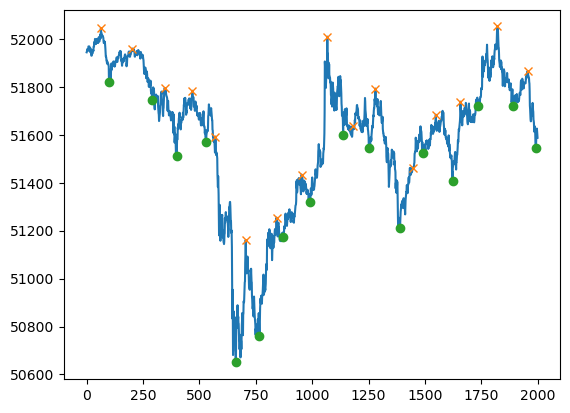

In [24]:
plt.plot(series[:,0])
plt.plot(peaks, data[peaks], "x")
plt.plot(min_peaks, data[min_peaks], "o")
# plt.axes([0,250,51600,52000])

# Buy at the local minima and sell at the local maxima
action_ini = np.array([0] * 2000)
action_ini[list(peaks)] = 2
action_ini[list(min_peaks)] = 1

In [25]:
env.reset()
total = 0
for i in range(1999):
    state, reward, done = env.step(action_ini[i])
    total += reward
print(total, env.state[0]*env.state[1]+env.state[2])

-1966.8019551918012 10.246015680169727


In [27]:
# Reset the environment to the initial state and get the initial state
state = env.reset()
total_points = 0
max_num_timesteps = 2000

total_point_history = []


# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# action_ini = [1, 2] * 1000
for t in range(max_num_timesteps):
        
    # From the current state S choose an action A using an ε-greedy policy
    state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
    try:
        q_values = q_network(state_qn)
    except Exception as e:
        print(e, state_qn)

    action = action_ini[t]
    
    # Take action A and receive reward R and the next state S'
    # next_state, reward, done, _ = env.step(action)
    next_state, reward, done = env.step(action)
    
    # Store experience tuple (S,A,R,S') in the memory buffer.
    # We store the done variable as well for convenience.
    memory_buffer.append(experience(state, action, reward, next_state, done))
    
    # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
    update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
    
    if update:
        # Sample random mini-batch of experience tuples (S,A,R,S') from D
        experiences = utils.get_experiences(memory_buffer)
        
        # Set the y targets, perform a gradient descent step,
        # and update the network weights.
        agent_learn(experiences, GAMMA)
    
    state = next_state.copy()
    total_points += reward
    
    if done:
        break
        
total_point_history.append(total_points)
# av_latest_points = np.mean(total_point_history[-num_p_av:])

print(f"\rTotal point in the first episodes: {av_latest_points:.2f}", end="")


NameError: name 'av_latest_points' is not defined

In [ ]:
start = time.time()

num_episodes = 100
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights()) 

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        try:
            q_values = q_network(state_qn)
        except Exception as e:
            print(e, state_qn)

        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        # next_state, reward, done, _ = env.step(action)
        next_state, reward, done = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 2000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('trading_model_1.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

In [ ]:
# Plot the point history
utils.plot_history(total_point_history)

In [ ]:
q_network.save('trading_model_2.h5')

## Deployment

In [ ]:
model = tf.keras.models.load_model('trading_model_2.h5')

In [ ]:
env_1 = Coinworld(series[-2000:])

In [ ]:
total_reward = 0
state = env_1.reset()
print(state[0]*state[1]+state[2])
for i in range(1500):
    q_values =  q_network(np.expand_dims(state, axis=0))
    action = np.argmax(q_values.numpy()[0])
    print(f'        {action}')
    # state, reward, done = env_1.step(action)
    total_reward += reward 
qty, cost, cash, duration = env_1.acc_state
print(qty*cost+cash)


In [ ]:
total_reward = 0
state = env_1.reset()
for i in range(100):
    q_values =  model(np.expand_dims(state, axis=0))
    action = random.randint(1,3)
    print(action)
    state, reward, done = env_1.step(action)
    total_reward += reward 
print(total_reward)

## Conclusion
The model stay idle

